# **Import Required Libraries**

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

# Warnings
import warnings
warnings.filterwarnings('ignore')


# **Load the Three Files**

In [4]:
# Load red and white datasets
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

# Add color column to distinguish datasets
red['color'] = 'red'
white['color'] = 'white'

# Combine datasets if needed (optional)
wine = pd.concat([red, white], axis=0)

# Display shapes
print("Red Wine Shape:", red.shape)
print("White Wine Shape:", white.shape)
print("Combined Dataset Shape:", wine.shape)

# Display first few rows
wine.head()


Red Wine Shape: (1599, 13)
White Wine Shape: (4898, 13)
Combined Dataset Shape: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


# **Initial Inspection**

In [5]:
# Check for missing values
print("Missing values per column:")
print(red.isnull().sum())

# Summary statistics
print(red.describe().T)

# Data types
print(red.dtypes)


Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64
                       count       mean        std      min      25%  \
fixed acidity         1599.0   8.319637   1.741096  4.60000   7.1000   
volatile acidity      1599.0   0.527821   0.179060  0.12000   0.3900   
citric acid           1599.0   0.270976   0.194801  0.00000   0.0900   
residual sugar        1599.0   2.538806   1.409928  0.90000   1.9000   
chlorides             1599.0   0.087467   0.047065  0.01200   0.0700   
free sulfur dioxide   1599.0  15.874922  10.460157  1.00000   7.0000   
total sulfur dioxide  1599.0  46.467792  32.895324  6.00000  22.0000   
density               1599.0   0.996747   0.00

 # **Exploratory Data Analysis (EDA)**

## **Target Distribution**

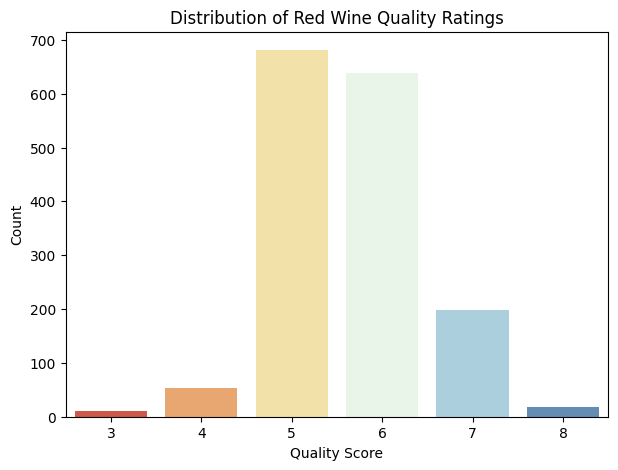

In [6]:
plt.figure(figsize=(7,5))
sns.countplot(x='quality', data=red, palette='RdYlBu')
plt.title('Distribution of Red Wine Quality Ratings')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()


## **Correlation Heatmap**

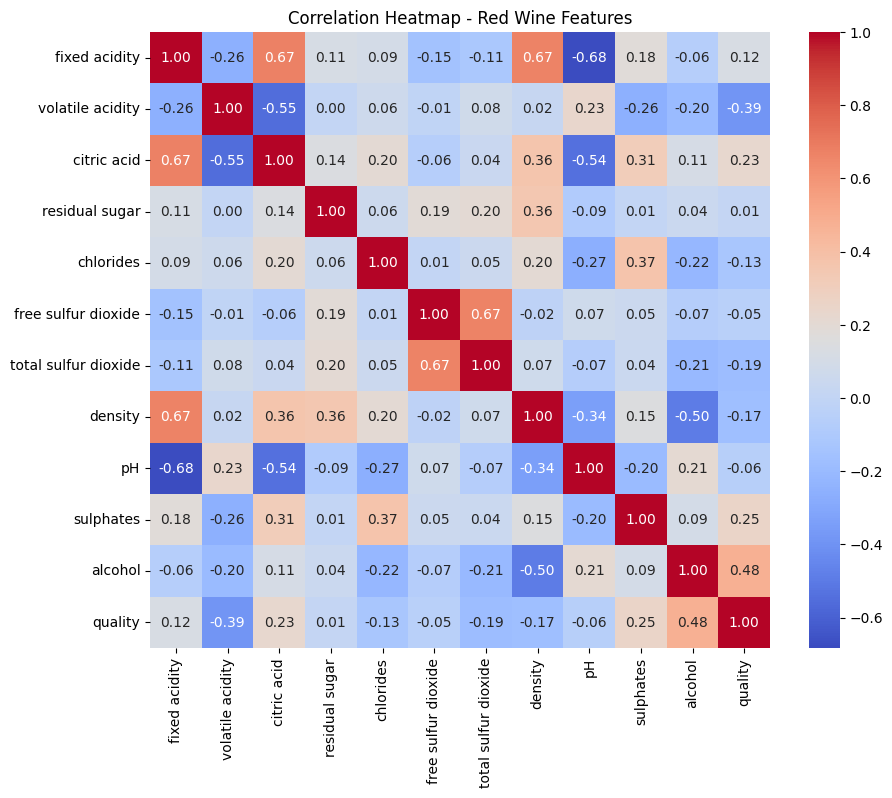

In [8]:
plt.figure(figsize=(10,8))
# Drop the 'color' column before calculating correlation
sns.heatmap(red.drop('color', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap - Red Wine Features')
plt.show()

## **Feature Distributions**

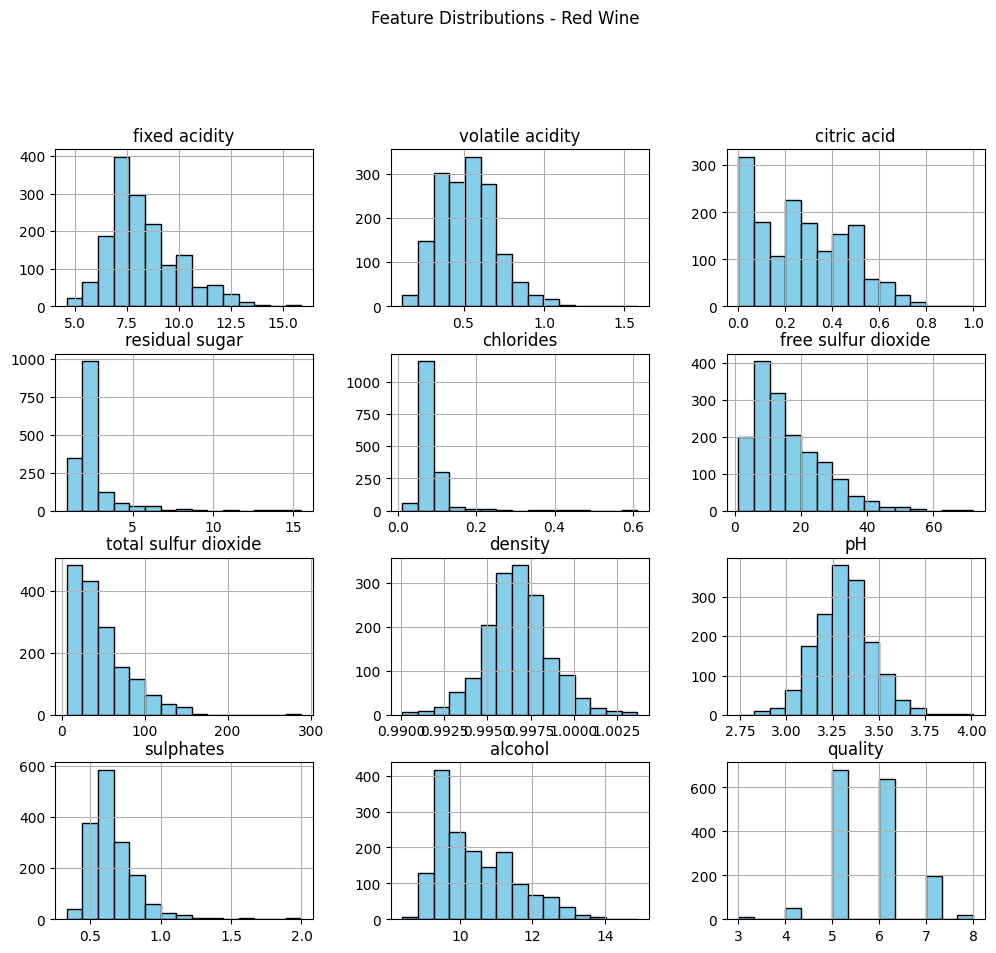

In [9]:
red.hist(bins=15, figsize=(12,10), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions - Red Wine', y=1.02)
plt.show()


# **Quality vs Key Features**

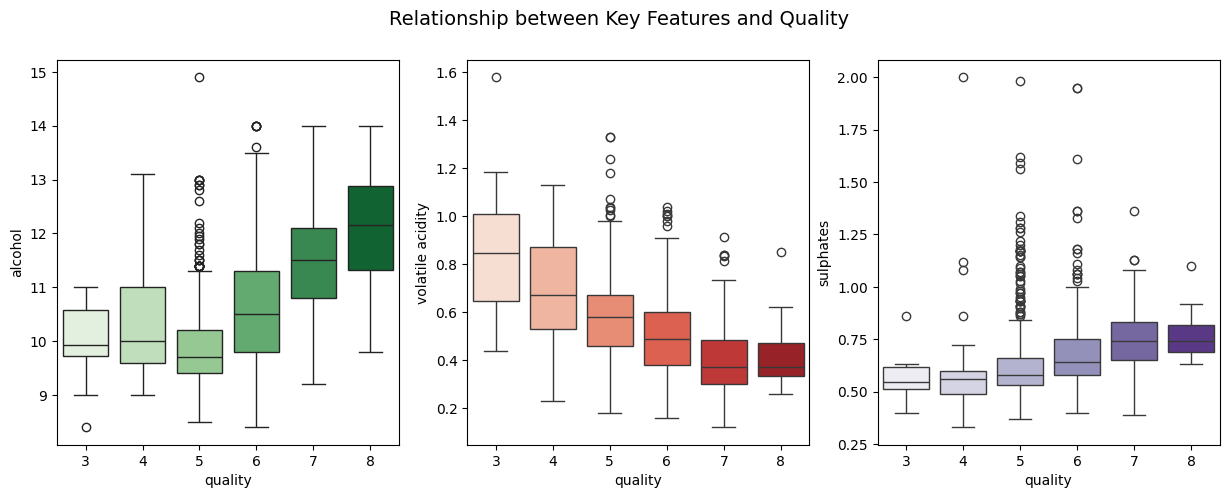

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(x='quality', y='alcohol', data=red, ax=axes[0], palette='Greens')
sns.boxplot(x='quality', y='volatile acidity', data=red, ax=axes[1], palette='Reds')
sns.boxplot(x='quality', y='sulphates', data=red, ax=axes[2], palette='Purples')
fig.suptitle('Relationship between Key Features and Quality', fontsize=14)
plt.show()


# **Data Preprocessing**

## **Binary Classification**

In [12]:
# Convert quality to binary label (0=low, 1=high)
red['quality_label'] = red['quality'].apply(lambda x: 1 if x >= 6 else 0)
print(red['quality_label'].value_counts())


quality_label
1    855
0    744
Name: count, dtype: int64


##**Feature / Target Split**

In [13]:
X = red.drop(['quality', 'color', 'quality_label'], axis=1)
y = red['quality_label']


## **Train-Test Splita**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


## **Feature Scaling**

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## **Handle Class Imbalance**

In [17]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_bal))


Before SMOTE: [595 684]
After SMOTE: [684 684]


# **Model Building & Evaluation**

In [18]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("-"*40)
    return acc, prec, rec, f1


## **Logistic Regression**

In [19]:
log_reg = LogisticRegression(max_iter=1000)
evaluate_model(log_reg, X_train_bal, y_train_bal, X_test_scaled, y_test)


Model: LogisticRegression
Accuracy: 0.747 | Precision: 0.800 | Recall: 0.702 | F1: 0.748
----------------------------------------


(0.746875, 0.8, 0.7017543859649122, 0.7476635514018691)

## **Random Forest**

In [20]:
rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42)
evaluate_model(rf, X_train_bal, y_train_bal, X_test_scaled, y_test)


Model: RandomForestClassifier
Accuracy: 0.797 | Precision: 0.819 | Recall: 0.795 | F1: 0.807
----------------------------------------


(0.796875, 0.8192771084337349, 0.7953216374269005, 0.8071216617210683)

## **Gradient Boosting**

In [21]:
gb = GradientBoostingClassifier(
    n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
evaluate_model(gb, X_train_bal, y_train_bal, X_test_scaled, y_test)


Model: GradientBoostingClassifier
Accuracy: 0.812 | Precision: 0.840 | Recall: 0.801 | F1: 0.820
----------------------------------------


(0.8125, 0.8404907975460123, 0.8011695906432749, 0.8203592814371258)

## **Compare Models**

In [22]:
results = []
for model in [log_reg, rf, gb]:
    acc, prec, rec, f1 = evaluate_model(model, X_train_bal, y_train_bal, X_test_scaled, y_test)
    results.append({'Model': model.__class__.__name__, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1})
pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)


Model: LogisticRegression
Accuracy: 0.747 | Precision: 0.800 | Recall: 0.702 | F1: 0.748
----------------------------------------
Model: RandomForestClassifier
Accuracy: 0.797 | Precision: 0.819 | Recall: 0.795 | F1: 0.807
----------------------------------------
Model: GradientBoostingClassifier
Accuracy: 0.812 | Precision: 0.840 | Recall: 0.801 | F1: 0.820
----------------------------------------


,Model,Accuracy,Precision,Recall,F1-Score
2,GradientBoostingClassifier,0.812500,0.840491,0.801170,0.820359
1,RandomForestClassifier,0.796875,0.819277,0.795322,0.807122
0,LogisticRegression,0.746875,0.800000,0.701754,0.747664


## **Confusion Matrix for Best Model**

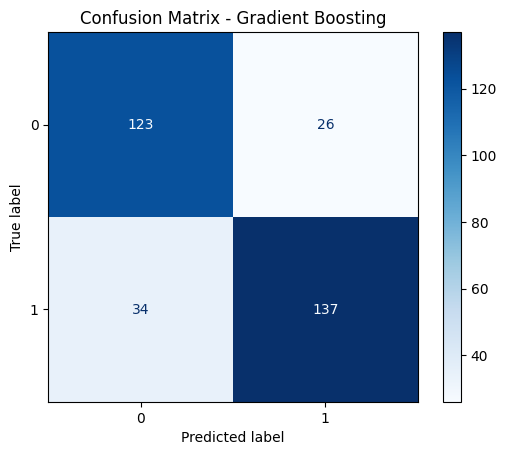

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model = gb  # Gradient Boosting is expected to perform best
y_pred = best_model.predict(X_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()


## **Cross Validation**

In [24]:
for model in [log_reg, rf, gb]:
    scores = cross_val_score(model, X_train_bal, y_train_bal, cv=5, scoring='f1')
    print(f"{model.__class__.__name__} Mean F1-Score: {scores.mean():.3f} (+/- {scores.std():.3f})")


LogisticRegression Mean F1-Score: 0.736 (+/- 0.024)
RandomForestClassifier Mean F1-Score: 0.813 (+/- 0.041)
GradientBoostingClassifier Mean F1-Score: 0.796 (+/- 0.047)
